In [1]:
# Installation
!pip install git+https://github.com/openai/CLIP.git
# Download weights
!wget https://github.com/Zasder3/model_soups_colab/releases/download/weights/checkpoint_10.1.pt
!wget https://github.com/Zasder3/model_soups_colab/releases/download/weights/checkpoint_10.2.pt
!wget https://github.com/Zasder3/model_soups_colab/releases/download/weights/checkpoint_10.3.pt
!wget https://github.com/Zasder3/model_soups_colab/releases/download/weights/checkpoint_10.4.pt
!wget https://github.com/Zasder3/model_soups_colab/releases/download/weights/checkpoint_10.5.pt
!wget https://github.com/Zasder3/model_soups_colab/releases/download/weights/cifar1098_idxs.npy

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ljx0uh1u
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ljx0uh1u
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.5 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=14308287efa1f140dace830f475e090bb8ce472c53ee648113db16af999f79c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-742owi34/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
--2023-09-16 04:15:09--  https://github.com/Zasder3/model_soups_colab/releases/download/weights/checkpoint_10.1.pt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Locatio

# Model Soups 🍲

By starting with a pretrained model, we can perform supervised finetuning on a new task. Instead of only taking the best performing model of all of our runs, the authors found that we can do some principled averaging to achieve a better set of weights! To learn more read their excellent [paper](https://arxiv.org/abs/2203.05482).

Here we start with CLIP ViT-B/32 and finetune on CIFAR10. The authors of the paper generously provided finetuned weights! I've saved us some time and uploaded the first 5 to GitHub.
All models can be found [here](https://drive.google.com/drive/folders/1KWNs03JRJM7i1CI3Mybpc9TsATY-fXNI).

In [2]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from torchvision.datasets import CIFAR10
from torchvision.transforms import *
from tqdm.notebook import tqdm

In [3]:
from torch.utils.data.dataset import Subset
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC

def _convert_image_to_rgb(image):
    return image.convert("RGB")


def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=BICUBIC),
        CenterCrop(n_px),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

transforms = _transform(224)

idxs = np.load('cifar1098_idxs.npy').astype('int')
indices = []
for i in range(len(idxs)):
  if idxs[i]:
    indices.append(i)

val = CIFAR10(root='./data', train=True, download=True, transform=transforms)
val = Subset(val, indices)
test = CIFAR10(root='./data', train=False, download=True, transform=transforms)

valloader = torch.utils.data.DataLoader(val,
                                        batch_size=128,
                                        shuffle=False,
                                        num_workers=2,
                                        drop_last=False)
testloader = torch.utils.data.DataLoader(test,
                                         batch_size=128,
                                         shuffle=False,
                                         num_workers=2,
                                         drop_last=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 78002600.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
def validate(model):
  preds = []
  labels = []
  for x, y in tqdm(valloader):
    x = x.to(device)
    y = y.to(device)
    preds.append(model(x).argmax(dim=1))
    labels.append(y)
  return torch.mean((torch.cat(preds) == torch.cat(labels)).float()).item()

def test(model):
  preds = []
  labels = []
  for x, y in tqdm(testloader):
    x = x.to(device)
    y = y.to(device)
    preds.append(model(x).argmax(dim=1))
    labels.append(y)
  return torch.mean((torch.cat(preds) == torch.cat(labels)).float()).item()

In [5]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model, feature_dim, num_classes, normalize=False, initial_weights=None):
        super(ModelWrapper, self).__init__()
        self.model = model
        self.classification_head = torch.nn.Linear(feature_dim, num_classes)
        self.normalize = normalize
        if not self.normalize:
            print('normalize skipped.')

        if initial_weights is not None and type(initial_weights) == tuple:
            print('tuple.')
            w, b = initial_weights
            self.classification_head.weight = torch.nn.Parameter(w.clone())
            self.classification_head.bias = torch.nn.Parameter(b.clone())
        else:
            if initial_weights is None:
                initial_weights = torch.zeros_like(self.classification_head.weight)
                torch.nn.init.kaiming_uniform_(initial_weights, a=math.sqrt(5))
            self.classification_head.weight = torch.nn.Parameter(initial_weights.clone())
            # Note: modified. Initial bug in forgetting to zero bias.
            self.classification_head.bias = torch.nn.Parameter(torch.zeros_like(self.classification_head.bias))

        # Note: modified. Get rid of the language part.
        delattr(self.model, 'transformer')

    def forward(self, images):
        features = self.model.encode_image(images).float()
        if self.normalize:
            features = features / features.norm(dim=-1, keepdim=True)
        logits = self.classification_head(features)
        return logits

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
state_dicts = []

for f in os.listdir():
  if f[-2:] == 'pt':
    print(f'Loading {f}')
    state_dicts.append(torch.load(f, map_location=device))

Loading checkpoint_10.1.pt
Loading checkpoint_10.2.pt
Loading checkpoint_10.4.pt
Loading checkpoint_10.5.pt
Loading checkpoint_10.3.pt


In [7]:
def get_model(state_dicts, alphal):
  model, _ = clip.load('ViT-B/32')
  feature_dim = state_dicts[0]['classification_head.weight'].shape[1]
  num_classes = state_dicts[0]['classification_head.weight'].shape[0]
  normalize = True
  model = ModelWrapper(model, feature_dim, num_classes, normalize)
  sd = {k : state_dicts[0][k].clone() * alphal[0] for k in state_dicts[0].keys()}
  for i in range(1, len(state_dicts)):
      for k in state_dicts[i].keys():
          sd[k] = sd[k] + state_dicts[i][k].clone() * alphal[i]
  model.load_state_dict(sd)
  model = model.to(device)
  return model

# Baseline 🏁
Before we show the power of soup, we need to so where we stand with no fancy tricks. Off to the validation set!

In [8]:
val_results = []
test_results = []

for i in range(len(state_dicts)):
  model, _ = clip.load('ViT-B/32')
  feature_dim = state_dicts[0]['classification_head.weight'].shape[1]
  num_classes = state_dicts[0]['classification_head.weight'].shape[0]
  normalize = True
  model = ModelWrapper(model, feature_dim, num_classes, normalize)
  model.load_state_dict(state_dicts[i])
  model = model.to(device)

  val_results.append(validate(model))
  test_results.append(test(model))

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 170MiB/s]


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Model 1'),
  Text(1, 0, 'Model 2'),
  Text(2, 0, 'Model 3'),
  Text(3, 0, 'Model 4'),
  Text(4, 0, 'Model 5')])

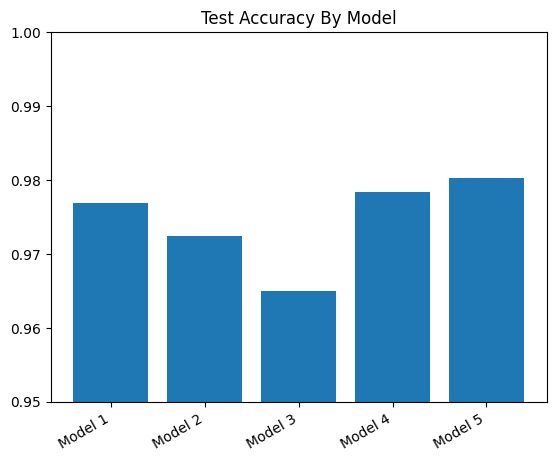

In [9]:
names = [f'Model {i+1}' for i in range(len(state_dicts))]
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
plt.ylim([0.95,1])
plt.xticks(rotation=30, ha='right')

# Let's Make Soup! 🍜

From here our next step is to see what happens when we make soup the naïve way using simple averaging. This is called "Uniform Soup."

In [10]:
alphal = [1 / len(state_dicts) for i in range(len(state_dicts))]
model = get_model(state_dicts, alphal)
test_results.append(test(model))

  0%|          | 0/79 [00:00<?, ?it/s]

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Model 1'),
  Text(1, 0, 'Model 2'),
  Text(2, 0, 'Model 3'),
  Text(3, 0, 'Model 4'),
  Text(4, 0, 'Model 5'),
  Text(5, 0, 'Uniform Soup')])

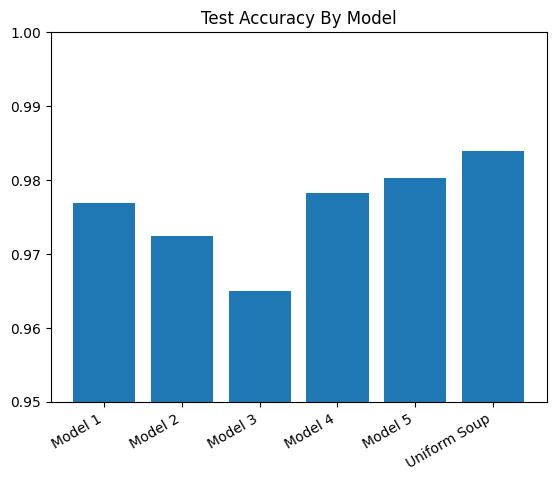

In [11]:
names.append("Uniform Soup")
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
plt.ylim([0.95,1])
plt.xticks(rotation=30, ha='right')

# Greedy Soup 😈
So how can we improve from our naïve, but still impressive, baseline? The answer is "Greedy Soup!"

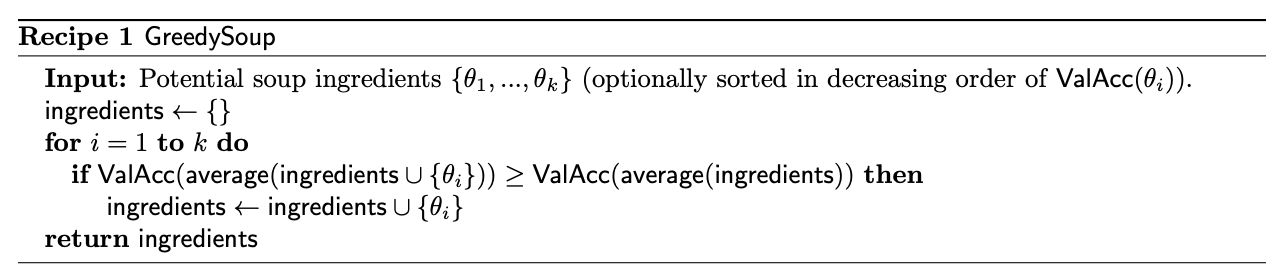

In [12]:
ranked_candidates = [i for i in range(len(state_dicts))]
ranked_candidates.sort(key=lambda x: -val_results[x])

current_best = val_results[ranked_candidates[0]]
best_ingredients = ranked_candidates[:1]
for i in range(1, len(state_dicts)):
  # add current index to the ingredients
  ingredient_indices = best_ingredients \
    + [ranked_candidates[i]]
  alphal = [0 for i in range(len(state_dicts))]
  for j in ingredient_indices:
    alphal[j] = 1 / len(ingredient_indices)

  # benchmark and conditionally append
  model = get_model(state_dicts, alphal)
  current = validate(model)
  print(f'Models {ingredient_indices} got {current*100}% on validation.')
  if current > current_best:
    current_best = current
    best_ingredients = ingredient_indices



  0%|          | 0/40 [00:00<?, ?it/s]

Models [4, 0] got 98.69999885559082% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [4, 0, 3] got 98.87999892234802% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [4, 0, 3, 1] got 98.83999824523926% on validation.


  0%|          | 0/40 [00:00<?, ?it/s]

Models [4, 0, 3, 2] got 98.83999824523926% on validation.


In [13]:
alphal = [0 for i in range(len(state_dicts))]
for j in best_ingredients:
  alphal[j] = 1 / len(best_ingredients)
model = get_model(state_dicts, alphal)

test_results.append(test(model))

  0%|          | 0/79 [00:00<?, ?it/s]

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Model 1'),
  Text(1, 0, 'Model 2'),
  Text(2, 0, 'Model 3'),
  Text(3, 0, 'Model 4'),
  Text(4, 0, 'Model 5'),
  Text(5, 0, 'Uniform Soup'),
  Text(6, 0, 'Greedy Soup')])

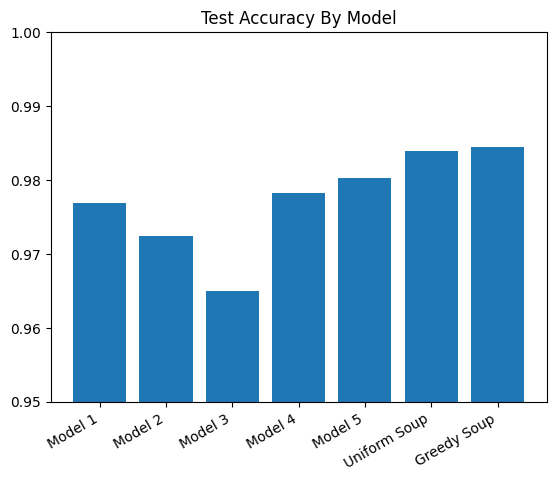

In [14]:
names.append("Greedy Soup")
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
plt.ylim([0.95,1])
plt.xticks(rotation=30, ha='right')